论文：LLaMA: Open and Efficient Foundation Language Models

https://github.com/meta-llama/llama

LLaMA 是一系列从 7 B到 65B 参数的基础语言模型。Meta 训练这些模型使用了数万亿个 token，并且证明了完全可以只使用公开可得的数据集来训练最先进的模型，而无需使用专有和不可获取的数据集。

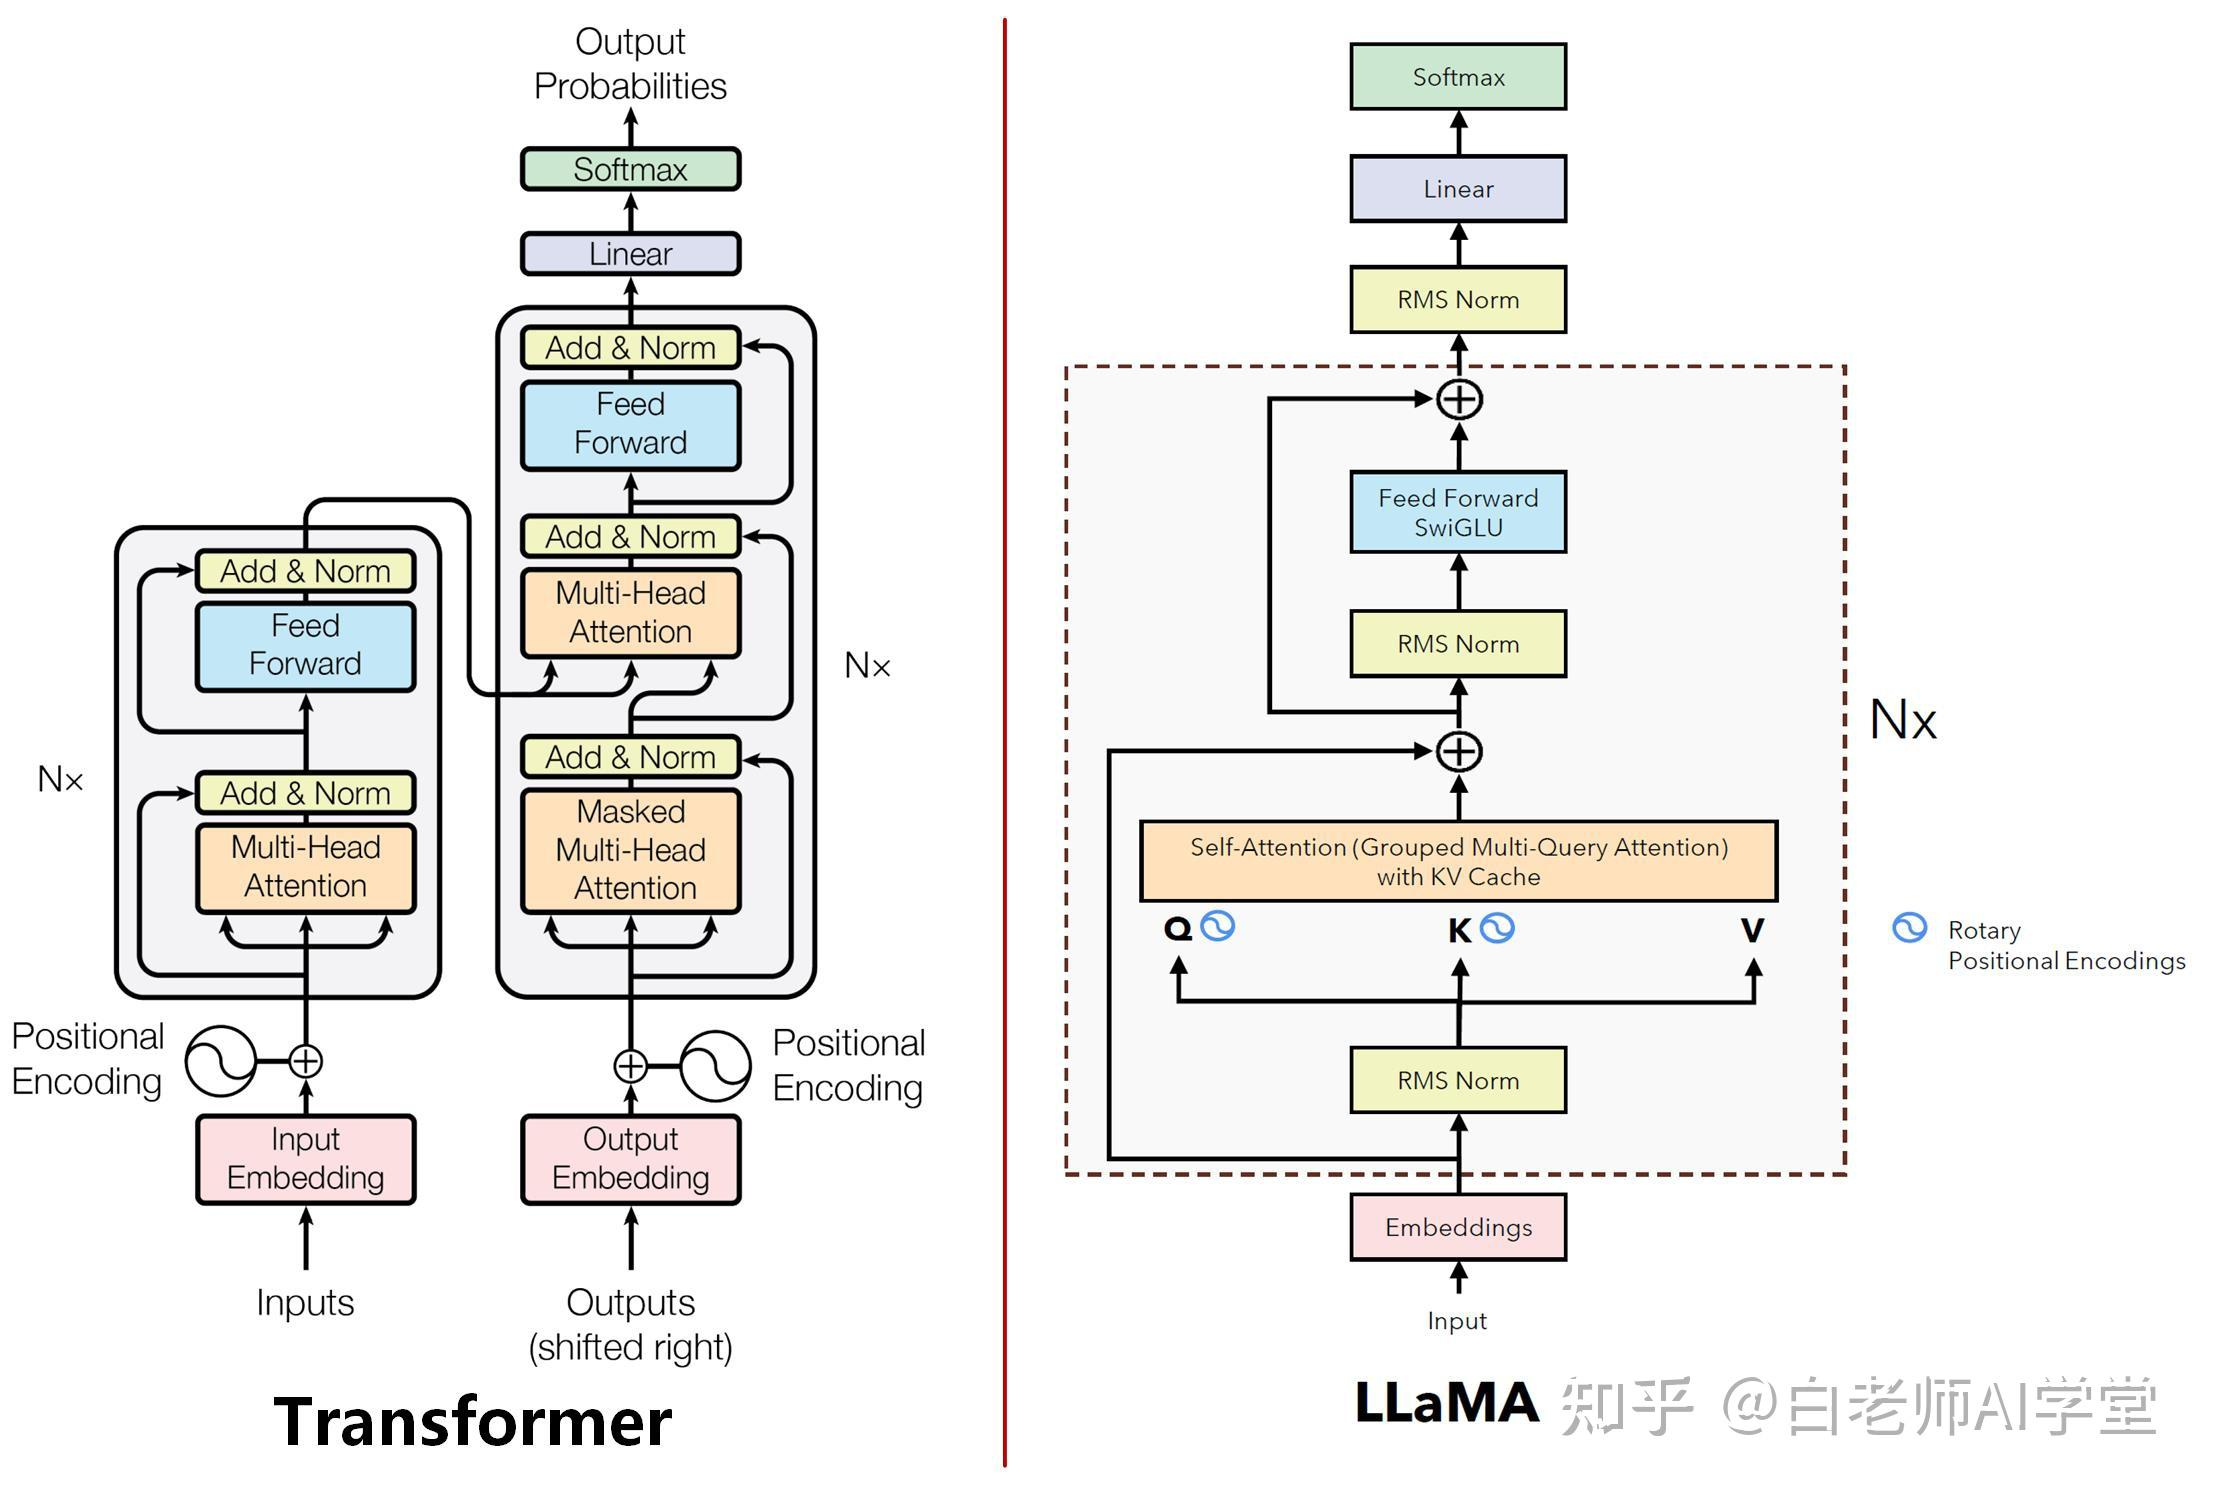

# tokenizer
使用字节对编码（BPE）算法对数据进行分词，使用 SentencePiece 的实现。值得注意的是，作者将所有数字分割成单个数字。

In [ ]:
import os
from logging import getLogger
from typing import List

from sentencepiece import SentencePieceProcessor


logger = getLogger()


class Tokenizer:
    def __init__(self, model_path: str):
        # reload tokenizer
        assert os.path.isfile(model_path), model_path
        self.sp_model = SentencePieceProcessor(model_file=model_path)
        logger.info(f"Reloaded SentencePiece model from {model_path}")

        # BOS / EOS token IDs
        self.n_words: int = self.sp_model.vocab_size()
        self.bos_id: int = self.sp_model.bos_id()
        self.eos_id: int = self.sp_model.eos_id()
        self.pad_id: int = self.sp_model.pad_id()
        logger.info(
            f"#words: {self.n_words} - BOS ID: {self.bos_id} - EOS ID: {self.eos_id}"
        )
        assert self.sp_model.vocab_size() == self.sp_model.get_piece_size()

    def encode(self, s: str, bos: bool, eos: bool) -> List[int]:
        assert type(s) is str
        t = self.sp_model.encode(s)
        if bos:
            t = [self.bos_id] + t
        if eos:
            t = t + [self.eos_id]
        return t

    def decode(self, t: List[int]) -> str:
        return self.sp_model.decode(t)

# LLaMa 模型架构

LLaMa 使用了 RMSNorm 归一化函数。

**RMSNorm**（Root Mean Square Normalization）和**LayerNorm**（Layer Normalization）是两种常用的归一化技术，它们在神经网络中有不同的应用和效果。

**主要区别：**

1. **计算方式**：
    - **RMSNorm**：它通过计算特征的均方根（RMS）来进行归一化。均方根是指所有值的平方和的平均值再开平方。
    - **LayerNorm**：它通过计算特征的均值和方差来进行归一化。

2. **适用场景**：
    - **RMSNorm**：通常用在在训练过程中更稳定的情况。这种归一化方法对序列数据（如RNN和Transformer）有很好的效果。
    - **LayerNorm**：它在大多数神经网络中都可以使用，尤其是在Transformer模型中广泛应用。

3. **效果**：
    - **RMSNorm**：计算速度较快，因为只需要计算均方根值而非均值和方差。
    - **LayerNorm**：计算稍慢，但能更好地处理不同尺度的输入。

**为什么选择RMSNorm**：

- **稳定性**：RMSNorm对梯度消失和爆炸问题有更好的稳定性，特别是在深层网络中。
- **计算效率**：计算均方根比计算均值和方差更高效，能加快训练速度。
- **应用特定**：在一些特定应用中，如序列数据，RMSNorm可能表现更好。

In [2]:
import torch

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

# SwiGLU 激活函数

 Swish(x) = x*sigmoid(ßx)

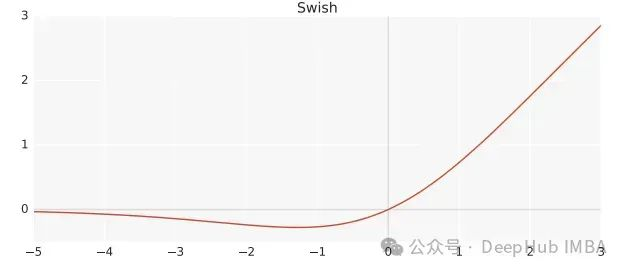

Swish可以比ReLU激活函数更好，因为它在0附近提供了更平滑的转换，这可以带来更好的优化。

1、Swish对于负值的响应相对较小克服了 ReLU 某些神经元上输出始终为零的缺点

2、GLU 的门控特性，这意味着它可以根据输入的情况决定哪些信息应该通过、哪些信息应该被过滤。这种机制可以使网络更有效地学习到有用的表示，有助于提高模型的泛化能力。在大语言模型中，这对于处理长序列、长距离依赖的文本特别有用。

3、SwiGLU 中的参数 W1,W2,W3,b1,b2,b3 可以通过训练学习，使得模型可以根据不同任务和数据集动态调整这些参数，增强了模型的灵活性和适应性。

4、计算效率相比某些较复杂的激活函数（如 GELU）更高，同时仍能保持较好的性能。这对于大规模语言模型的训练和推理是很重要的考量因素。


选择 SwiGLU  作为大语言模型的激活函数，主要是因为它综合了非线性能力、门控特性、梯度稳定性和可学习参数等方面的优势。在处理语言模型中复杂的语义关系、长依赖问题、以及保持训练稳定性和计算效率方面，SwiGLU 表现出色，因此被广泛采用。

In [4]:
 import torch.nn as nn
 
 class SwiGLU(nn.Module):
     
     def __init__(self, w1, w2, w3) -> None:
         super().__init__()
         self.w1 = w1
         self.w2 = w2
         self.w3 = w3
     
     def forward(self, x):
         x1 = F.linear(x, self.w1.weight)
         x2 = F.linear(x, self.w2.weight)
         hidden = F.silu(x1) * x2
         return F.linear(hidden, self.w3.weight)

# 旋转位置编码（RoPE）

什么是大模型外推性？

外推性是指大模型在训练时和预测时的输入长度不一致，导致模型的泛化能力下降的问题。例如，如果一个模型在训练时只使用了512个 token 的文本，那么在预测时如果输入超过512个 token，模型可能无法正确处理。这就限制了大模型在处理长文本或多轮对话等任务时的效果。

 
LLM：旋转位置编码（RoPE）的通俗理解 https://zhuanlan.zhihu.com/p/690610231


# AdamW 优化器

(todo)

超参数为：β1 = 0.9，β2 = 0.95。

使用 cosine 学习率衰减策略，2000 步的 warm-up，最终学习率等于最大学习率的 10%，使用 0.1 的权重衰减和 1.0 的梯度裁剪。

## loss
https://zhuanlan.zhihu.com/p/652657011


1、preprocess_pretrain_dataset处理PreTraining阶段的数据

数据组成形式：
输入input： <bos> X1 X2 X3
标签labels：X1 X2 X3 </s>
典型的Decoder架构的数据训练方式；


2、preprocess_supervised_dataset处理SFT阶段的数据

数据组成形式：
输入input：<bos> prompt response
标签labels： -100 ... -100 response </s>
这里面labels的重点在于prompt部分的被-100所填充，主要作用在下面会介绍到。